###  **DIALLO ALPHA OUMAR**

#### **Réseaux de neurones convolutifs.**
                                            

> Dans ce travail, nous allons aborder les réseaux de neurones convolutifs ( CNN ). Initialement, nous développerons et évaluerons notre propre réseau de neurones pour une tâche de classification sur des données de TensorFlow via l'API tf.keras.datasets. Par la suite, nous mettrons en œuvre des modèles pré-entraînés disponibles dans Keras. Nous procéderons en fin à une brève comparaison des différents modèles notamment en se basant sur des metrics tels que la matrice de confusion , l'accuracy.

# Importation des bibiothèques

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Importation des données

Comme nous l'avons dit précédemment, nous allons utiliser le dataset "cats_vs_dogs", qui est un ensemble de données bien connu dans le domaine de la classification d'images. Il contient un grand nombre d'images de chats et de chiens. Notre objectif sera donc d'entraîner un modèle capable de reconnaitre ces deux annimaux.

In [ ]:
dataset_name = "cats_vs_dogs"
(ds_full,), ds_info = tfds.load(dataset_name, split=["train"], with_info=True, as_supervised=True)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteWB332B/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


# Séparons les données en Train , Valdidation et Test.

In [ ]:
train_ds_size = int(0.75 * len(ds_full))
valid_ds_size = int(0.16 * len(ds_full))

ds_train = ds_full.take(train_ds_size)
remaining = ds_full.skip(train_ds_size)
ds_val = remaining.take(valid_ds_size)
ds_test = remaining.skip(valid_ds_size)

# Visulalisons quelques images

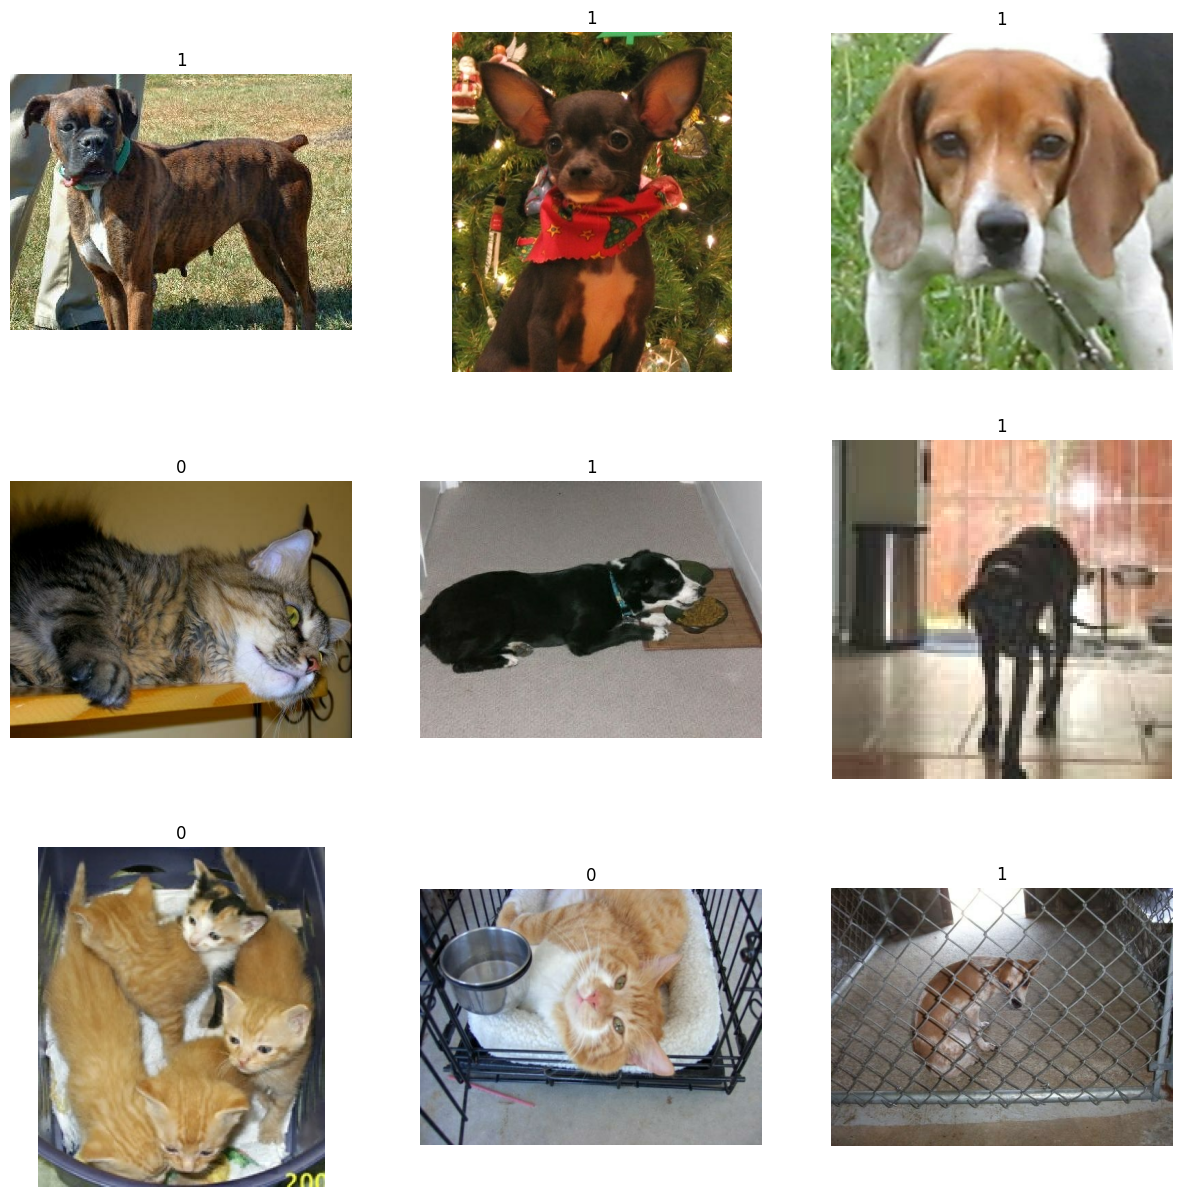

In [ ]:
import matplotlib.pyplot as plt

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]

plt.figure(figsize = (15,15))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(label))
    plt.axis("off")

# Resizing

In [ ]:
IMG_SIZE = 299
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

# One-hot / categorical encoding

In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

batch_size=16
ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

#Fonction de Data augmentation

In [ ]:
from keras.layers import Rescaling, RandomFlip, RandomRotation
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

In [ ]:
#AUTOTUNE pour optimiser la taille du buffer
train_ds = ds_train.prefetch(buffer_size=32)
val_ds = ds_val.prefetch(buffer_size=32)

# Création de notre propre modèle CNN

In [ ]:
img_height, img_width =size
input_shape = (img_height, img_width, 3)
model = Sequential()
model.add(tf.keras.Input(shape=input_shape))

# Preprocessing
model.add(data_augmentation)
model.add(Rescaling(1./255))

# Model
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 297, 297, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 148, 148, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 146, 32)      9248      
                                                      

> Notre modèle séquentiel comprend quatre couches de convolution, chacune suivie d'une activation ReLU et d'un max pooling, réduisant progressivement la taille des features tout en augmentant la profondeur des filtres de 32 à 64. Après les couches convolutives, les données sont aplaties et passent par une couche dense de 64 neurones avec activation ReLU et une couche de dropout pour limiter le surajustement. Le modèle se termine par une couche de sortie dense avec deux neurones et une activation softmax pour la classification binaire. Au total, le modèle comporte environ 1,08 million de paramètres entraînables.

# Compilation du modèle

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Entrainement

In [ ]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15
1090/1090 [==============================] - 63s 55ms/step - loss: 0.6946 - accuracy: 0.5082 - val_loss: 0.6933 - val_accuracy: 0.4938
Epoch 2/15
1090/1090 [==============================] - 61s 56ms/step - loss: 0.6934 - accuracy: 0.5099 - val_loss: 0.6913 - val_accuracy: 0.5331
Epoch 3/15
1090/1090 [==============================] - 61s 56ms/step - loss: 0.6896 - accuracy: 0.5317 - val_loss: 0.6873 - val_accuracy: 0.5515
Epoch 4/15
1090/1090 [==============================] - 62s 57ms/step - loss: 0.6775 - accuracy: 0.5741 - val_loss: 0.6496 - val_accuracy: 0.6277
Epoch 5/15
1090/1090 [==============================] - 61s 56ms/step - loss: 0.6412 - accuracy: 0.6366 - val_loss: 0.6116 - val_accuracy: 0.6711
Epoch 6/15
1090/1090 [==============================] - 63s 58ms/step - loss: 0.5878 - accuracy: 0.6928 - val_loss: 0.5334 - val_accuracy: 0.7381
Epoch 7/15
1090/1090 [==============================] - 61s 56ms/step - loss: 0.5443 - accuracy: 0.7309 - val_loss: 0.4828 -

Nous constatons une progression constante de notre modèle à travers les époques, atteignant finalement une accuracy de 83% sur l'ensemble de validation et 82% sur le train. Cette amélioration, malgré une fluctuation temporaire, souligne la capacité du modèle à généraliser. Nous aurions pu augmenter les épochs car le loss semble ne pas être linéaire (continue de diminuer) , mais nous n'avons pas assez de ressource. Nous nous limitons donc sur ce modèle qui est dejà pas mal avec ses 83% sur l'ensemble de validation. Nous pouvons dès à présent le tester sur les données de Test.

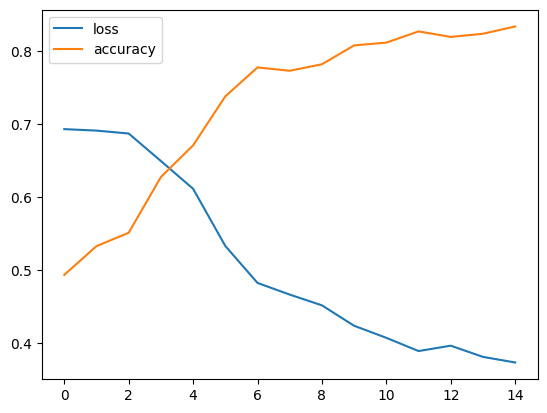

In [ ]:
import pandas as pd
import numpy as np
pd.Series(history.history['val_loss']).plot(label='loss')
pd.Series(history.history['val_accuracy']).plot(label='accuracy')
plt.legend()

# Prédiction sur le Test et matrice de confusion

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    # Convertir les probabilités en indices de classe prédits
    preds_indices = np.argmax(preds, axis=1)
    labels_indices = np.argmax(labels, axis=1)

    y_pred.extend(preds_indices)
    y_true.extend(labels_indices.numpy() if hasattr(labels_indices, 'numpy') else labels_indices)


1/1 [==============================] - 0s 27ms/step


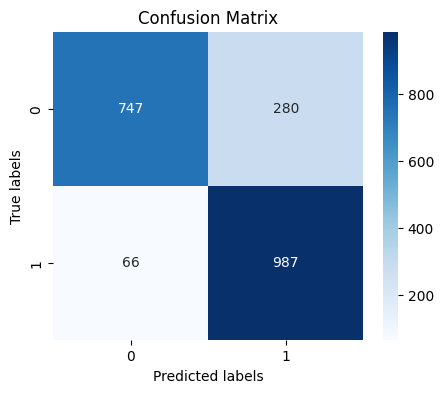

In [ ]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Ci-dessous nous avons la matrice de confusion sur les données Test. On voit qu'il a bien classé 1734 images
Et qu'il s'est trompé sur 346 img. Il est néanmoins légérement performant pour réconnaitre la classe 1.

## Visualisation des labels prédites

1/1 [==============================] - 0s 28ms/step


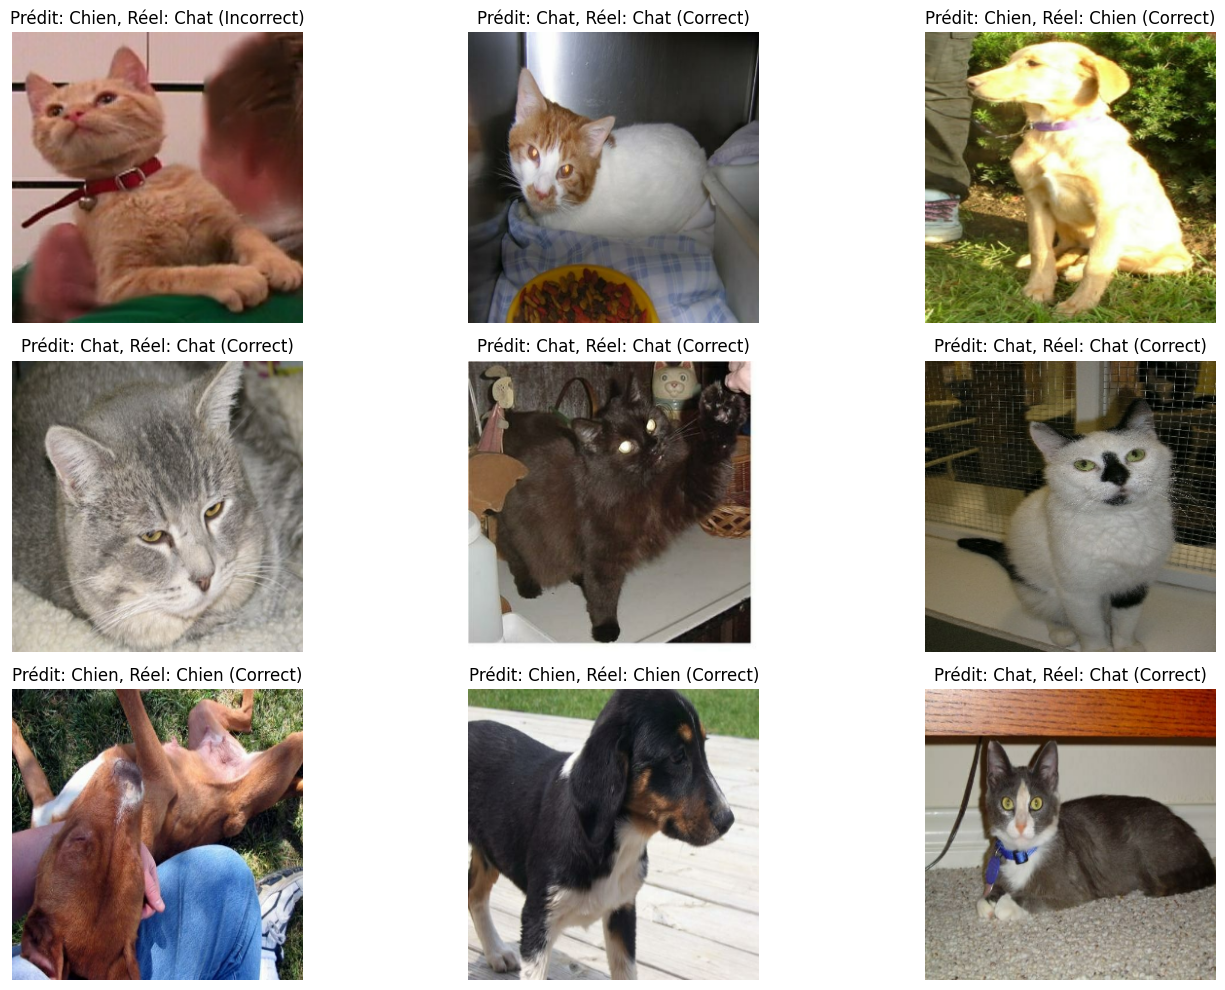

In [ ]:
import matplotlib.pyplot as plt

images_to_show = 9
plt.figure(figsize=(15, 10))

for images, labels in ds_test.take(1):
    preds = model.predict(images)
    preds_indices = np.argmax(preds, axis=1)
    labels_indices = np.argmax(labels.numpy(), axis=1)

    for i in range(images_to_show):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = labels_indices[i]
        pred_label = preds_indices[i]


        class_names = ["Chat", "Chien"]

        correct = "Correct" if true_label == pred_label else "Incorrect"
        title = f"Prédit: {class_names[pred_label]}, Réel: {class_names[true_label]} ({correct})"
        plt.title(title)
        plt.axis("off")

plt.tight_layout()
plt.show()

> Dens les 9 images ci-dessous, que nous avons prédits avec le modèle, il s'est trompé qu'une seule fois. Donc comme on l'a bien dit dans les parties précédentes; le modèle performe bien sur les nouvelles données. Il est néanmoins très difficile d'expliquer pourquoi il s'est trompé sur le chat 1 qu'il a prédit en chien.

#### Maintenant nous allons fine-Tuner un modèle pré entrainer pour voir s'il peut faire mieux.

# FineTune des modèles pré entrainés.

# Model VGG19
> Dans cette partie, nous allons nous inspirer de ce que nous avons fait en cours avec le VGG16. Nous allons nous, utiliser le modèle pré entrainer VGG19 qui est une version légèrement plus profonde avec 19 couches avec des poids, composée de 16 couches convolutives et de 3 couches entièrement connectées. Nous l'utiliserons pour faire le processing de nos images et ensuite on utilise un modèle de machine learning pour faire la classification. On pense à un random forest ou un SVM.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

def input_preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.vgg19.preprocess_input(image)  # Prétraitement spécifique à VGG19
    label = tf.one_hot(label, NUM_CLASSES)  # Application du one-hot encoding aux labels
    return image, label

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    image, label = input_preprocess(image, label)
    return image, label

batch_size = 16
ds_train_n = ds_train.batch(batch_size)
ds_val_n = ds_val.batch(batch_size)
ds_test_n = ds_test.batch(batch_size)


# Applicons la fonction de prétraitement et de data augmentation sur le dataset d'entraînement
ds_train_n = ds_train_n.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_n = ds_val_n.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_n = ds_test_n.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

**Attention si vous devais exécuter le code ci-dessus , vous devez rélancer le chargement du dataSet au début et ainsi que la séparation en Train et Test, sans oublier le Resizing fait juste après la visualisation des images de début. Car sinon vous utiliserez les prétaitements faites pour le model précédent qui seront pas les mêmes que pour le VGG19. Donc ça va générer une erreur.**

### Combinaison des fonction data process et data augmentation

> Nous rappelons qu'on utilise le data augmentation car nous avons expérienté dans le modèle précédent qu'en augmentant les données, le modèle est plus performant.

In [ ]:
#AUTOTUNE pour optimiser la taille du buffer
ds_train_n = ds_train_n.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val_n = ds_val_n.prefetch(buffer_size=tf.data.AUTOTUNE)


# Importation du modèle

In [ ]:
from tensorflow.keras.applications import VGG19

# Chargement du modèle VGG19 pré-entraîné sans les couches supérieures
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Aajoutons un GlobalAveragePooling pour réduire la dimensionnalité des caractéristiques extraites
model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])


In [ ]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notre modèle séquentiel comprend deux parties principales. La première partie est constituée du modèle VGG19 utilisé comme un extracteur de caractéristiques. Ce modèle, avec ses 20 024 384 paramètres, transforme chaque image d'entrée en un ensemble de caractéristiques de taille 7x7x512. La seconde partie du modèle est une couche de Global Average Pooling qui réduit la dimensionnalité des caractéristiques extraites en prenant la moyenne sur les dimensions spatiales, résultant en un vecteur de 512 caractéristiques pour chaque image. Cette simplification permet de réduire significativement le nombre de paramètres nécessaires pour les couches suivantes, tout en conservant les informations essentielles.

# Fonction pour extraire les caractéristiques

In [ ]:
import numpy as np
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        # Extraction des caractéristiques
        extracted_features = model1.predict(images)
        features.extend(extracted_features)
        # Convertir les labels one-hot en labels entiers
        labels.extend(tf.argmax(lbls, axis=1).numpy())
    return np.array(features), np.array(labels)

# Extraction des caractéristiques et des labels
features_train, labels_train = extract_features(ds_train_n)
features_val, labels_val = extract_features(ds_val_n)
features_test, labels_test = extract_features(ds_test_n)

1/1 [==============================] - 4s 4s/step


## Utilisation d'un SVM pour faire la classification
> Dans cette partie nous allons faire la classification avec un SVC. On utilisera un grid search pour faire une optimisation des hyper paramètres et ainsi espérer avoir un meilleur modèl à la fin

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Normalisation des caractéristiques
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Construction du modèle SVC avec des hyperparamètres choisis
model2 = SVC(C=1.0, kernel='rbf', gamma='scale')

# Entraînement du modèle
model2.fit(features_train_scaled, labels_train)

# Prédiction sur l'ensemble de test
predictions2 = model2.predict(features_test_scaled)

# Évaluons le modèle
test_accuracy2 = accuracy_score(labels_test, predictions2)
print(f'Accuracy sur l\'ensemble de test: {test_accuracy2:.4f}')
print(classification_report(labels_test, predictions2))

Accuracy sur l'ensemble de test: 0.9905
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1034
           1       0.99      0.99      0.99      1061

    accuracy                           0.99      2095
   macro avg       0.99      0.99      0.99      2095
weighted avg       0.99      0.99      0.99      2095



Nous avons un excellent modèle avec un accaruracy incroyable de 99% sur l'ensmeble Test. Nous sommes un peu surpris des performances de l'extraction des caractéristiques extraites pour le **VGG19**. Nous voyons que ce modèl est très puissant. En la combinant avec un SVM . Nous arrivons à classer 99% de nos images. Nous remarquons qu'autant la classe zéro que la classe 1 est très bien distingué.

In [ ]:
# Évaluer le modèle sur l'ensemble d'entraînement
train_accuracy2 = model2.score(features_train_scaled, labels_train)

print(f'Accuracy sur l\'ensemble d\'entraînement: {train_accuracy2:.4f}')

Accuracy sur l'ensemble d'entraînement: 0.9951


Nous remarquons également que sur l'ensemble d'entrainement le modèle avait fait un accuracy de 99%. sur le train Donc en bref il a supper bien appris et a super bien généraliser.

# Matrice de confusion

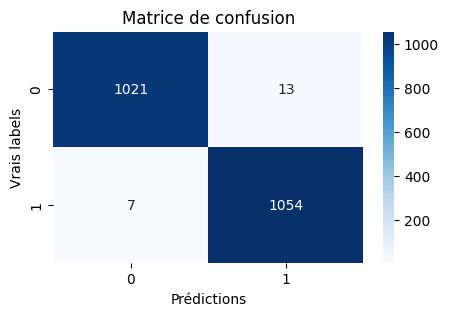

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Génération des prédictions sur l'ensemble de test
predictions2 = model2.predict(features_test_scaled)

# Calcul de la matrice de confusion
cm2 = confusion_matrix(labels_test, predictions2)

# Affichage de la matrice de confusion
plt.figure(figsize=(5,3))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vrais labels')
plt.title('Matrice de confusion')
plt.show()

La matrice de confusion, ne fait que confirmer ce qu'on a dit ci-haut. Le modèle classe vraiment presque toutes les images. On peut recalculer à travers cette matrice l'accuracy en faisant (TP+TN/Total) et on obtient bien 99%.

# Visualisations des labels prédits avec les images du Test.

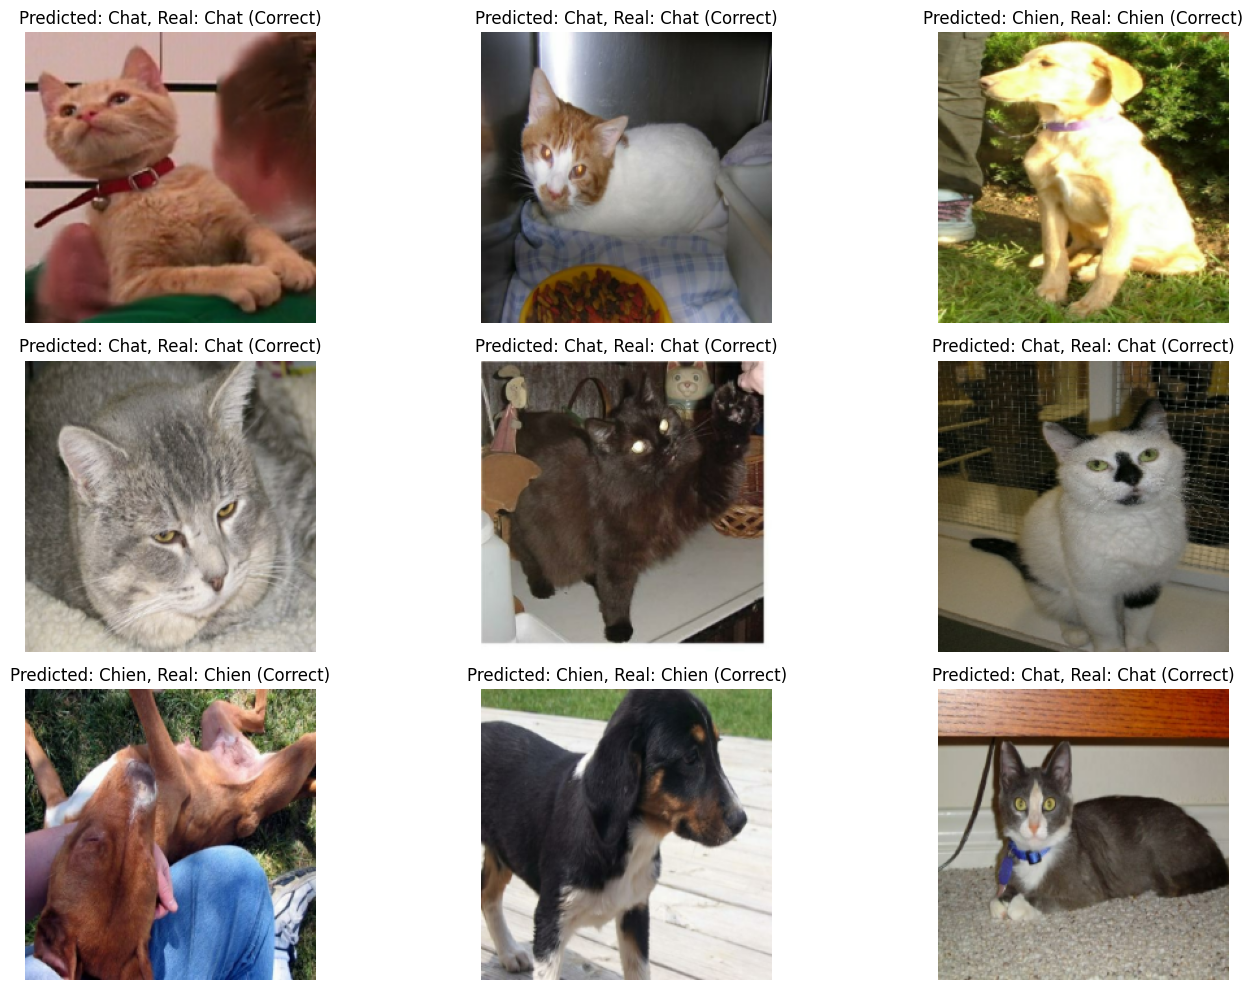

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

#On résize avant d'utiliser
TARGET_SIZE = (224, 224)


def resize_image(image, label):
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.cast(image, tf.uint8)
    return image, label

ds_test_resized = ds_test.map(resize_image)

# On va choisir juste 9 images à afficher
images_to_show =9
plt.figure(figsize=(15, 10))
for images_batch, labels_batch in ds_test_resized.batch(images_to_show).take(1):
    preds_batch = predictions2[:images_to_show]
    for i in range(images_to_show):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(images_batch[i]).numpy())
        true_label = labels_batch[i].numpy()
        pred_label = preds_batch[i]
        class_names = ["Chat", "Chien"]
        correct = "Correct" if true_label == pred_label else "Incorrect"
        title = f"Predicted: {class_names[pred_label]}, Real: {class_names[true_label]} ({correct})"
        plt.title(title)
        plt.axis("off")

plt.tight_layout()
plt.show()


Nous rémarquons que le modèle ne se trompe sur aucune image prédite.

# FineTuner le modèle InceptionResNetV2

> Dans cette 3ème et dernière partie, nous allons fineTuner un autre modèle pré entrainé. Cette fois ci , on l'utilisera tout seul en retirant la dernière couche. Et l'adapter à notre problème de classification.


> InceptionResNetV2 est un autre modèle de réseau de neurones convolutif qui combine les idées des architectures Inception et ResNet. Proposé par Google, ce modèle utilise la structure modulaire des blocs Inception, qui permettent une augmentation efficace de la largeur et de la profondeur du réseau sans coût computationnel excessif, tout en intégrant les connexions résiduelles de ResNet pour faciliter la propagation du gradient à travers le réseau, permettant ainsi d'entraîner des architectures plus profondes.


# Téléchargement configuration du modèle.

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model3 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajout d'une nouvelle couche GlobalAveragePooling
x = base_model3.output
x = GlobalAveragePooling2D()(x)

# Ajout d'une couche fully-connected
x = Dense(64, activation='relu')(x)

predictions3 = Dense(2, activation='softmax')(x)

model3 = Model(inputs=base_model3.input, outputs=predictions3)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()


219055592/219055592 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

 Le modèle totalise environ 55,91 millions de paramètres, dont 55,85 millions sont entraînables. Il est vraiment très profond. Les paramètres non entraînables, au nombre de 60.544, proviennent probablement des couches de normalisation et autres mécanismes internes à InceptionResNetV2 qui sont gardés constants.

# Prétaitement pour InceptionResnet

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

batch_size=16
def input_preprocess_inception(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def preprocess_and_augment_inception(image, label):
    image = data_augmentation(image)
    image, label = input_preprocess_inception(image, label)
    return image, label

# Application du prétraitement et de la data augmentation sur les datasets
ds_train_inception = ds_train.map(preprocess_and_augment_inception, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_inception = ds_val.map(input_preprocess_inception, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_inception = ds_test.map(input_preprocess_inception, num_parallel_calls=tf.data.AUTOTUNE)

# Préparation des datasets pour l'entraînement
ds_train_inception = ds_train_inception.batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val_inception = ds_val_inception.batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test_inception = ds_test_inception.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Entrainement

In [ ]:
epochs = 10

#Entraînement du modèle
history3 = model3.fit(ds_train_inception,epochs=epochs,validation_data=ds_val_inception)


Epoch 1/10
1091/1091 [==============================] - 442s 329ms/step - loss: 0.2161 - accuracy: 0.9131 - val_loss: 0.1383 - val_accuracy: 0.9363
Epoch 2/10
1091/1091 [==============================] - 351s 321ms/step - loss: 0.1370 - accuracy: 0.9471 - val_loss: 0.1513 - val_accuracy: 0.9390
Epoch 3/10
1091/1091 [==============================] - 350s 321ms/step - loss: 0.1179 - accuracy: 0.9537 - val_loss: 0.1169 - val_accuracy: 0.9511
Epoch 4/10
1091/1091 [==============================] - 350s 321ms/step - loss: 0.1059 - accuracy: 0.9584 - val_loss: 0.1260 - val_accuracy: 0.9484
Epoch 5/10
1091/1091 [==============================] - 350s 320ms/step - loss: 0.1012 - accuracy: 0.9604 - val_loss: 0.0852 - val_accuracy: 0.9656
Epoch 6/10
1091/1091 [==============================] - 349s 320ms/step - loss: 0.0887 - accuracy: 0.9645 - val_loss: 0.0803 - val_accuracy: 0.9675
Epoch 7/10
1091/1091 [==============================] - 349s 320ms/step - loss: 0.0833 - accuracy: 0.9674 - val_

In [ ]:
val_loss, val_acc = model3.evaluate(ds_val_inception)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

233/233 [==============================] - 25s 92ms/step - loss: 0.0766 - accuracy: 0.9694
Validation Loss: 0.0765611082315445
Validation Accuracy: 0.9693630933761597


Notre modèle performe très bien sur les données de validation avec un accuracy de 97% . I n'y pas de signe de surapprentissage apparante, il a commence à surajuster un peu vers la fin de l'époque 9 et on a l'impression qu'à l'époque 8 on avait dejà atteint le meilleur modèle. On s'attendait à ce score vu le score qu'on a fait précédement avec la combinaison du VGG19 et le SVM.

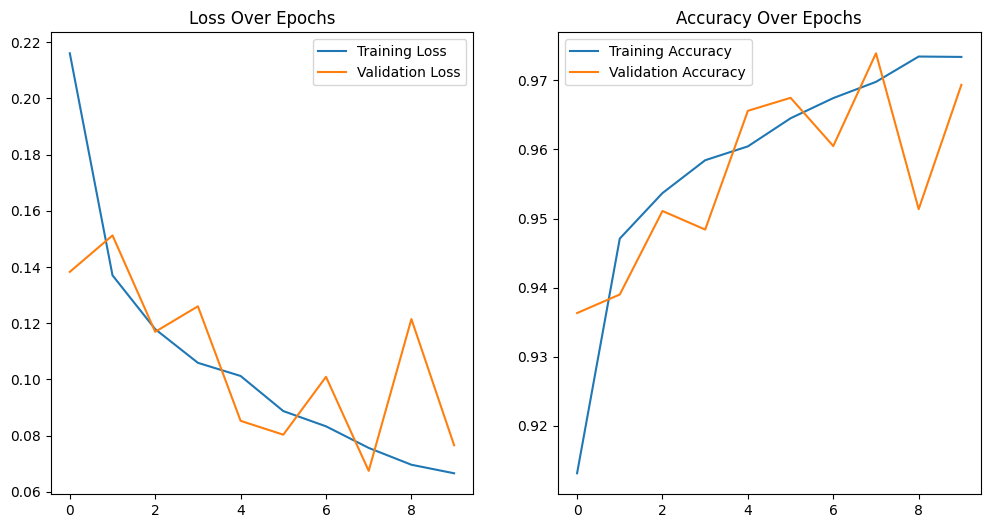

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

Les courbes ci-dessus nous montrent juste graphiquement ce qu'on a observer sur les détails de l'entrainement , le modèle ne montre pas de signe de surapprentissage.

# Prédition sur l'ensemble Test

In [ ]:
import numpy as np
import tensorflow as tf

# Récupérons les étiquettes réelles et les prédictions
y_true_test3 = []
y_pred_test3 = []
for images, labels in ds_test_inception:

    preds3 = model3.predict(images)

    preds_indices3 = np.argmax(preds3, axis=1)
    labels_indices3 = np.argmax(labels.numpy(), axis=1)

    y_pred_test3.extend(preds_indices3)
    y_true_test3.extend(labels_indices3)

1/1 [==============================] - 2s 2s/step


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true_test3, y_pred_test3, target_names=['Chat', 'Chien'])

print(report)

              precision    recall  f1-score   support

        Chat       0.95      0.98      0.97      1034
       Chien       0.98      0.95      0.96      1061

    accuracy                           0.97      2095
   macro avg       0.97      0.97      0.97      2095
weighted avg       0.97      0.97      0.97      2095



> Avec une précision de 95% pour les chats et 98% pour les chiens, notre modèle montre une grande performance sur les données de test. Il généralise bien.

# Matrice de Confusion

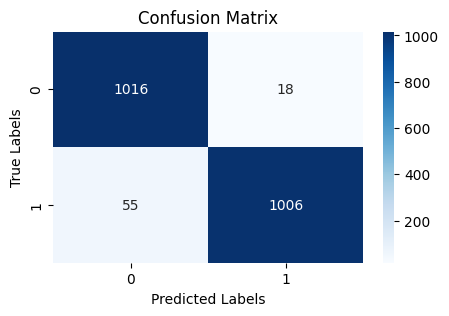

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


min_length = min(len(y_true_test3), len(y_pred_test3))
y_true_test3 = y_true_test3[:min_length]
y_pred_test3 = y_pred_test3[:min_length]

conf_matrix3 = confusion_matrix(y_true_test3, y_pred_test3)


# Calculons la matrice de confusion
conf_matrix_3 = confusion_matrix(y_true_test3, y_pred_test3)

# Affichons de la matrice de confusion
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

La matrice de confusion ci-dessus confirme notre analyse précédente. Le modèle semble d'ailleurs reconnaitre mieux de façon équilibré les deux classes que nos deux modèles précédents.

# Visualisons les labels prédites sur les images

1/1 [==============================] - 0s 44ms/step


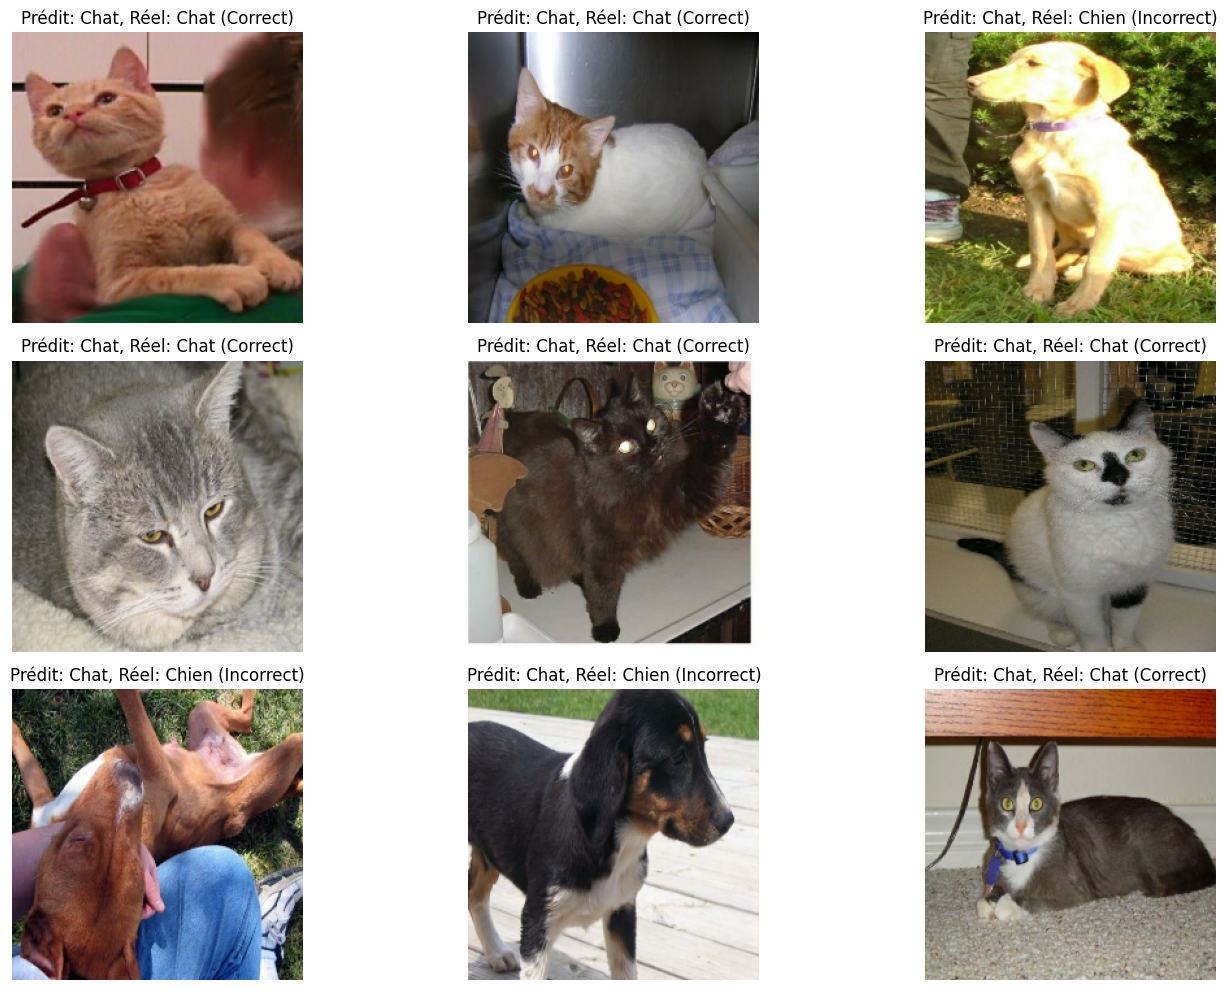

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


#On résize avant d'utiliser
TARGET_SIZE = (224, 224)


def resize_image3(image, label):
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.cast(image, tf.uint8)
    return image, label


#utilisons 9 images
images_to_show = 9
plt.figure(figsize=(15, 10))

ds_test_resized3 = ds_test.map(resize_image3).batch(images_to_show)
for images, labels in ds_test_resized3.take(1):
    # Faisons les prédictions avec notre modèle InceptionResNetV2
    preds3 = model3.predict(images)
    preds_indices3 = np.argmax(preds3, axis=1)
    labels_indices3 = labels.numpy()

    # Affichons les images et les prédictions
    for i in range(images_to_show):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = labels_indices3[i]
        pred_label = preds_indices3[i]

        class_names = ["Chat", "Chien"]  # Noms des classes

        correct = "Correct" if true_label == pred_label else "Incorrect"
        title = f"Prédit: {class_names[pred_label]}, Réel: {class_names[true_label]} ({correct})"
        plt.title(title)
        plt.axis("off")

plt.tight_layout()
plt.show()

> Nous voyons que le modèle sur les 9 imgages visualisées ne s'est trompé que sur l'image 3. On voit que chaque modèle a sa façon d'apprendre et on ne s'aurait dire avec précision comment il prends ses décisions.

# Conclusion

> Ce travail nous a permis de comprendre les réseaux de neurones convolutifs. L'utilisation des modèles pré entrainés. La combinaison d'un modèle de deep learning avec un modèle classique de ML qui peut donner de bons résultas. Le Modèle VGG19 combiné avec le SVM fait mieux dans ce jeu de donnée , on va dire que le VGG19 a pu extraire des caractéristiques très net avec des classes entièrement séparables , ce qui nous valu le score aussi élévé, mais on pourrait se demander si le modèle ne s'était pas donné entrainé sur des données d'animaux similaires. Quand au modèle InceptionResnet V2 , on voit qu'il est très performant également.